Notebook to train and analyze a Mixture of Experts architecture using label split on the default mnist dataset. Two experts are trained, one on the digits of \[0, 4\] and one on \[5, 9\]. In a second step a gating network is trained on a training set containing all ten digits and evaluated on the combined validation data from the experts. The training datasets are all disjoint from each other.

In [1]:
import torch
import torchvision
import numpy as np
from models.mnist.mnist_net import MnistNet
from models.mnist.generic_gating_network import GenericGatingNetwork
from models.mnist.gating_network import GatingNetwork
from datasets.mnist_dataset import MNISTDataset
from utils.plot_confusion_matrix import plot_confusion_matrix
from utils.dataset_utils import train_test_split, build_subset

In [2]:
transformations_mnist_default = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
])

transformations_mnist_swiss = torchvision.transforms.Compose([
                torchvision.transforms.Resize((28,28)),
                torchvision.transforms.Grayscale(),
                torchvision.transforms.ToTensor(),
])

In [3]:
torch.manual_seed(42)

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

In [4]:
# Preparing mnist datasets for all digits
# Preparing mnist datasets for all digits
mnist_dataset = MNISTDataset('../../data/default_mnist/training', transform=transformations_mnist_default)
mnist_train, mnist_valid = train_test_split(mnist_dataset, [0.8, 0.2])
mnist_test = MNISTDataset('../../data/default_mnist/testing', transform=transformations_mnist_default)

# Preparing mnist datasets for digits in [0, 4]
mnist_train_bottom = build_subset(mnist_train, [i for i in range(5)])
mnist_valid_bottom = build_subset(mnist_valid, [i for i in range(5)])
mnist_test_bottom = build_subset(mnist_test, [i for i in range(5)])

# Preparing mnist datasets for digits in [5, 9]
mnist_train_top = build_subset(mnist_train, [i for i in range(5, 10)])
mnist_valid_top = build_subset(mnist_valid, [i for i in range(5, 10)])
mnist_test_top = build_subset(mnist_test, [i for i in range(5, 10)])


In [5]:
bottom_expert = MnistNet(classes=[i for i in range(5)])
bottom_expert.load_state_dict(torch.load('./trained_models/label_split_semi/mnist_bottom_expert.pth'))
# bottom_expert.fit(
#     training_data=mnist_train_bottom,
#     validation_data=mnist_valid_bottom,
#     num_epochs=20,
#     batch_size=64,
#     device=device,
#     criterion=criterion,
#     optimizer=optimizer,
#     learning_rate=0.0005,
#     save_state_path='./trained_models/label_split_semi/mnist_bottom_expert.pth'
#     )

upper_expert = MnistNet(classes=[i for i in range(5, 10)])
upper_expert.load_state_dict(torch.load('./trained_models/label_split_semi/mnist_upper_expert.pth'))
# upper_expert.fit(
#     training_data=mnist_train_top,
#     validation_data=mnist_valid_top,
#     num_epochs=20,
#     batch_size=64,
#     device=device,
#     criterion=criterion,
#     optimizer=optimizer,
#     learning_rate=0.0005,
#     save_state_path='./trained_models/label_split_semi/mnist_upper_expert.pth'
#     )





<All keys matched successfully>

In [6]:
gate = GatingNetwork(classes=[i for i in range(10)], experts=[upper_expert, bottom_expert])

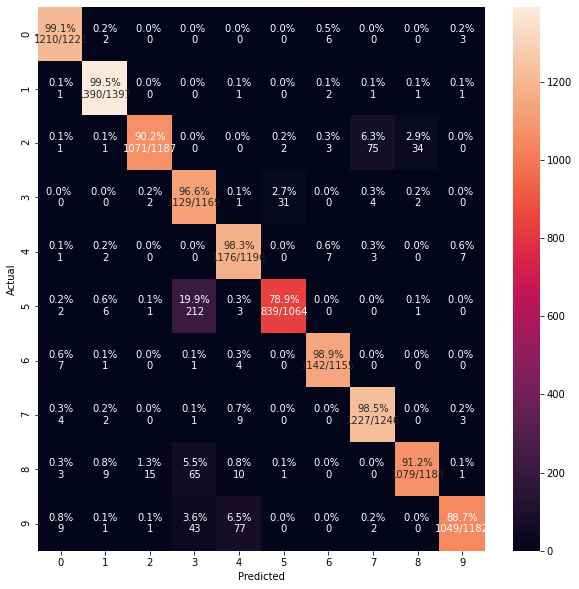

In [7]:
y_pred = gate.predict(mnist_valid, device)
y_true = mnist_valid.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])

In [8]:
gate.load_state_dict(torch.load('./trained_models/label_split_semi/gate.pth'))
# gate.fit(
#     training_data=mnist_train, 
#     validation_data=mnist_valid, 
#     num_epochs=20, 
#     batch_size=128, 
#     device=device, 
#     criterion=criterion, 
#     optimizer=optimizer, 
#     learning_rate=0.00005, 
#     save_state_path='./trained_models/label_split_semi/gate.pth'
#     )

<All keys matched successfully>

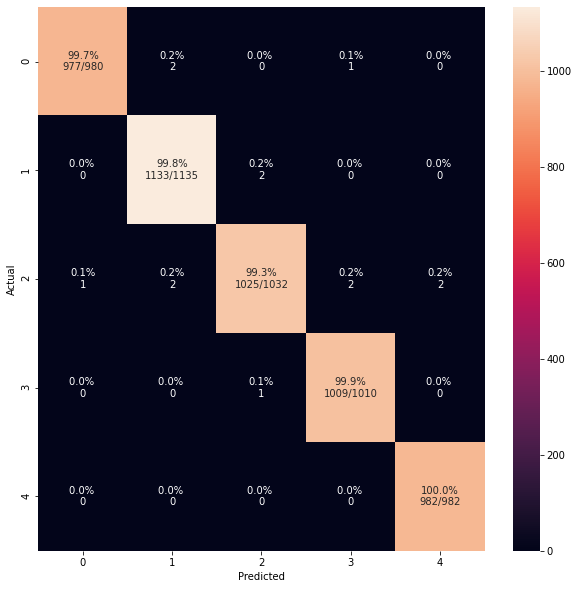

In [9]:
y_pred = bottom_expert.predict(mnist_test_bottom, device)
y_true = mnist_test_bottom.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(5)])

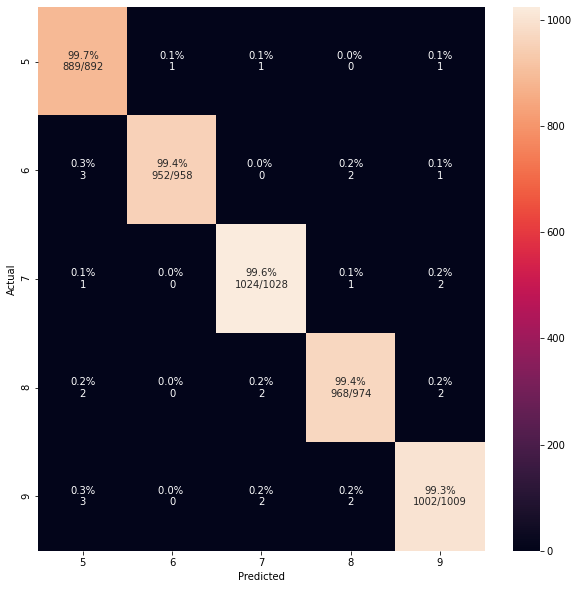

In [10]:
y_pred = upper_expert.predict(mnist_test_top, device)
y_true = mnist_test_top.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(5, 10)])

In [11]:
gate.evaluate(mnist_test, 128, criterion, device)

{'loss': 0.0393, 'acc': 0.987, 'entropy': 0.0683}

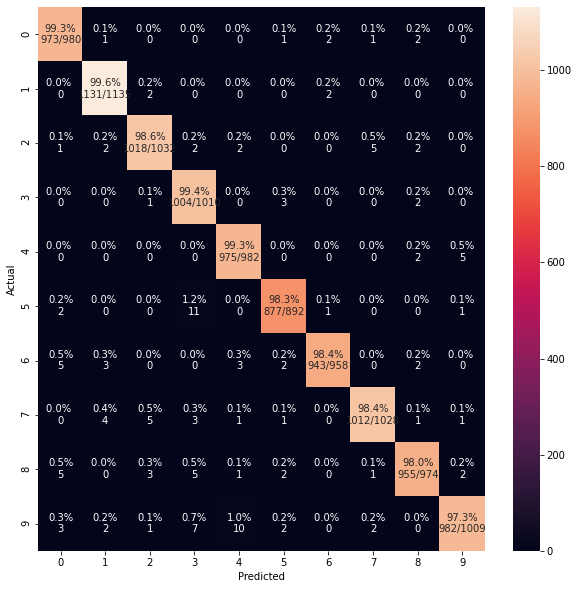

In [12]:
y_pred = gate.predict(mnist_test, device)
y_true = mnist_test.targets
plot_confusion_matrix(y_true, y_pred, [i for i in range(10)])